# Data Mining Pilot Study and Plan

## Background

The New York Times is one of the world’s most circulated newspapers with a history dating back to 1851. A lot has changed in society during the 150 plus year history of The Times, but few things have gained as much attention as the portrayal of women in media. Ever since the recent gender equality discussion (Carlsen, A., Salam, M., Miller, C.C., Lu, D. Ngu, A. Patel, J.K., & Wichter, Z., 2018) change seems to have sped up. It's become increasingly important for newspapers to be mindful of the way they represent women, in order to stay relevant and, perhaps most importantly, not suffer backlash resulting in damage to their image and credibility.

## Problem description

With the recent surge in coverage of media and its treatment of women, the New York Times is interested in looking at the optics of their own publications as it relates to gender. Looking back through history, they are interested in their difference in coverage of male and female subjects, as well as how this relates to the gender of the author.
Our first inquiry relates to how journalists affect the content and coverage that they deliver. According to a study by Armstrong, “the gender of the newswriter can be linked to gender portrayals within news stories.” (Armstrong, C.L., 2008) It suggests that the gender of selected sources and individuals that get covered is related to that of the journalist. Looking at NYT’s publications, we will examine if such a correlation can be found and how this might affect hiring decisions in the future.
Our second question pertains to the representation of women subjects in articles and other news items. According to Collins, Rebecca L. (Sex Roles; New York Vol. 64, Iss. 3-4) women are under-represented across a range of media and settings, including newspapers. Secondly when they are portrayed it is often in a negative manner. We want to research how the representation of women, in articles published by New York Times, has changed over the last 150 years. By doing so we can help NYT understand where they stand right now as it relates to gender representation, and how they have progressed over the years.

## Hypothesis

In our pilot study we set out to answer the following three hypotheses. They are all interesting for New York Times as it's a clear indicator of how gender-biased there news reporting and writting is.

* Female pronouns will be under-representated in the articles compared to male pronouns.
* Female pronouns will be higher representated in more negative articles
* The representation of female and male pronouns will differ for different news categories

## Data collection

The NYT dataset consists of all publicated newspapers from september 1851 up until last month. The data comes in batches consisting of all articles from a given month, in a given year (When using the NYT Archive API). In order produce a large enough data set, spanning a big enough time period, we make a request for 3 monthly periods from each desired year.

The data included from the articles are: headlines, lead paragraphs and some metadata (Type of article, date of publication, writer, subject category and so on).

The text data received from the NYT API is generally free from spelling and grammatical errors, due to the nature of the journalistic content (typically reviewed and well corrected). The relatively low amount of spelling and/or grammatical errors resulted in our decision to not look for, or clean the data of such errors. 

In order to keep the size of the data down, while still keeping the most critical data from the data set, we decided to select the lead paragraphs from the articles as the sole basis for the analysis. (the lead paragraphs contain the biggest amount of data, out of the available categories).

In [4]:
import pandas as pd
import numpy as np
import json
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
from urllib.request import urlopen
import re
import matplotlib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
# the following two lines set up our visualization settings
%matplotlib inline
matplotlib.pyplot.rcParams['figure.figsize'] = [10, 6]
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib
import seaborn as sns

import time

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Uncomment to download vader lexicon again for sentiment analysis
#nltk.download('vader_lexicon')


## Load files locally

In [415]:
# Change this value to false if making a new request to the API
load_papers_locally = True

# Only gather data from our selected time period 1965-2017.
#year_span = range(1965,2017, 1)
year_span = range(1990,2017, 1)
print(year_span)

# All the gathered years in a list
year = []
for number in year_span:
    year.append(number)

# If the data should be loaded from a local file
if(load_papers_locally):
    nyt_papers = joblib.load("nyt_papers_lead_paragraph_range(1990, 2017).pkl")

range(1990, 2017)


## Collect papers from New York Times API

Collects papers from March, June and September for the years 1965-2015

In [440]:
# Check if papers are gathered from saved file instead
if(load_papers_locally != True):
    nyt_papers = []

    collection_number = 1
    for year in year_span:
        # Get three samples for each year containing all the articles for the three different months.

        # SAMPLE 1
        sample1Json = pd.read_json("http://api.nytimes.com/svc/archive/v1/" + str(year) + "/3.json?api-key=c86bad0043d3407ebc5869abd10dade4")
        sample1 = pd.DataFrame(sample1Json.response.docs, columns=['section_name', 'lead_paragraph'])
                
        # SAMPLE 2
        sample2Json = pd.read_json("http://api.nytimes.com/svc/archive/v1/" + str(year) + "/6.json?api-key=c86bad0043d3407ebc5869abd10dade4")
        sample2 = pd.DataFrame(sample2Json.response.docs, columns=['section_name', 'lead_paragraph'])
        sample1.append(sample2)

        # SAMPLE 3
        sample3Json = pd.read_json("http://api.nytimes.com/svc/archive/v1/" + str(year) + "/9.json?api-key=c86bad0043d3407ebc5869abd10dade4")
        sample3 = pd.DataFrame(sample3Json.response.docs, columns=['section_name', 'lead_paragraph'])
        sample1.append(sample3)
        
        # Append all three samples to one collection
        nyt_papers.append(sample1)

        # Loading message
        print(str(collection_number) + "/" + str(len(year_span)) + " collections loaded")
        collection_number = collection_number + 1

    # Used to gather multiple collections (1 collection = 1 year worth of news papers)

1/27 collections loaded
2/27 collections loaded
3/27 collections loaded
4/27 collections loaded
5/27 collections loaded
6/27 collections loaded
7/27 collections loaded
8/27 collections loaded
9/27 collections loaded
10/27 collections loaded
11/27 collections loaded
12/27 collections loaded
13/27 collections loaded
14/27 collections loaded
15/27 collections loaded
16/27 collections loaded
17/27 collections loaded
18/27 collections loaded
19/27 collections loaded
20/27 collections loaded
21/27 collections loaded
22/27 collections loaded
23/27 collections loaded
24/27 collections loaded
25/27 collections loaded
26/27 collections loaded
27/27 collections loaded


In [777]:
# Save all the results and results for each category in this dataframe
result = pd.DataFrame({
    # All = Data for all the articles
    # male_pronoun_count = The totalt count of male pronouns for each collection
    # female_pronoun_count = The totalt count of female pronouns for each collection
    # male_pronoun_percentage = The percentage of pronouns that are considered male in the article
    # female_pronoun_percentage = The percentage of pronouns that are considered female in the article
    # word_count = The total amount of words in the collection
    # attitude = The compound value of the sentiment analysis. Ranging from: -1 negative, 0 neutral and +1 positive
    # difference_prounouns = The difference between male and female pronouns, holding the percentage of ...
    # ... pronouns in the article that are female. (female_pronouns / all_pronouns)
    'All': {
        'male_pronoun_count': [],
        'female_pronoun_count': [],
        'male_pronoun_percentage': [],
        'female_pronoun_percentage': [],
        'word_count': [],
        'attitude': [],
        'difference_pronouns': []
    }, 
    # Sports = Data for all the articles with the category sports
    'Sports': {
        'male_pronoun_count': [],
        'female_pronoun_count': [],
        'male_pronoun_percentage': [],
        'female_pronoun_percentage': [],
        'word_count': [],
        'attitude': [],
        'difference_pronouns': []
    }, 
    # Opinion = Data for all the articles with the category opinion
    'Opinion': {
        'male_pronoun_count': [],
        'female_pronoun_count': [],
        'male_pronoun_percentage': [],
        'female_pronoun_percentage': [],
        'word_count': [],
        'attitude': [],
        'difference_pronouns': []
    }, 
    # Business = Data for all the articles with the category business
    'Business': {
        'male_pronoun_count': [],
        'female_pronoun_count': [],
        'male_pronoun_percentage': [],
        'female_pronoun_percentage': [],
        'word_count': [],
        'attitude': [],
        'difference_pronouns': []
    }
})

# Female pronouns to match with the article content
female_pronouns = ["Ms.", "Mrs.", " she ", "She ", "Herself", "herself", "Her ", " her ", "Hers ", " hers "]

# Male pronouns to match with the article content
male_pronouns = ["Mr.", " he ", "He ", "His ", " his ", "Himself", "himself"]

# Count all the words, female and male pronouns in the collection (1 year of papers)
collection_word_count = 0
collection_female_pronoun_count = 0
collection_male_pronoun_count = 0

# Count the processed articles
articles_count = 0


# For sentiment analysis
sid = SentimentIntensityAnalyzer()
i = 0

# Loop through all collections (years) in the stored papers.
for collection in nyt_papers:
    i = i + 1
    
    # Save all compound values per collection in this list
    all_compound_values_list = []
    
    # Create a object to hold all the different category data per collection
    categories = {
        'Sports': {
            'male_pronoun_count': 0,
            'female_pronoun_count': 0,
            'word_count': 0,
            'attitude': []
        }, 
        'Opinion': {
            'male_pronoun_count': 0,
            'female_pronoun_count': 0,
            'word_count': 0,
            'attitude': []        
        }, 
        'Business': {
            'male_pronoun_count': 0,
            'female_pronoun_count': 0,
            'word_count': 0,
            'attitude': []
        }
    }
    
    # Loop through all the rows in the collection
    for index, row in collection.iterrows():
        article = row.lead_paragraph
        
        # Only process if the article has a lead paragraph
        if(article is not None):
            # Set the articles sentiment score (ss = sentiment score)
            ss = sid.polarity_scores(article)

            # Count the female pronouns for every article in the collection 
            article_female_pronoun_count = 0

            # Count all the female pronouns
            for pronoun in female_pronouns:
                article_female_pronoun_count += np.char.count(str(article), pronoun)
            collection_female_pronoun_count += article_female_pronoun_count

            # Count the female pronouns for every article in the collection 
            article_male_pronoun_count = 0
            
            # Count all the male pronouns
            for pronoun in male_pronouns:
                article_male_pronoun_count = article_male_pronoun_count + np.char.count(str(article), pronoun)
            collection_male_pronoun_count = collection_male_pronoun_count + article_male_pronoun_count
            
            # Add the articles compound sentiment score to the collections totalt score
            all_compound_values_list.append(ss['compound'])
            
            # Calculate the percentage of male and female pronouns in the article
            article_male_pronoun_percentage = article_male_pronoun_count / len(article)
            article_female_pronoun_percentage = article_female_pronoun_count / len(article)
            
            # Keep the count for all words in the collection
            collection_word_count += len(str(article).split())

            # For each category defined by us (Business, Opinion, Sports)
            for category in categories:
                # If the article has a category
                if row.section_name is None:
                    continue
                
                # If the articles category matches our defined categories
                if category in row.section_name:
                    # Save the data to the corresponding category
                    categories[category]['male_pronoun_count'] += article_male_pronoun_count
                    categories[category]['female_pronoun_count'] += article_female_pronoun_count
                    categories[category]['word_count'] += len(str(article).split())
                    categories[category]['attitude'].append(ss['compound'])
            
            # Increase the article counter after the article have been processed
            articles_count = articles_count + 1
    
    # Save the average result for each attribute after all articles in the collection have been processed
    result['All']['male_pronoun_count'].append(collection_male_pronoun_count)
    result['All']['female_pronoun_count'].append(collection_female_pronoun_count)
    result['All']['male_pronoun_percentage'].append(collection_male_pronoun_count / collection_word_count)
    result['All']['female_pronoun_percentage'].append(collection_female_pronoun_count / collection_word_count)
    result['All']['word_count'].append(collection_word_count)
    result['All']['attitude'].append(sum(all_compound_values_list)/len(all_compound_values_list))
    result['All']['difference_pronouns'].append(collection_female_pronoun_count / (collection_female_pronoun_count + collection_male_pronoun_count))
    
    # Save the average result for each category for each attribute after 
    # all articles in the collection have been processed
    for category in categories:
        result[category]['male_pronoun_count'].append(categories[category]['male_pronoun_count'])
        result[category]['female_pronoun_count'].append(categories[category]['female_pronoun_count'])
        result[category]['male_pronoun_percentage'].append(categories[category]['male_pronoun_count'] / categories[category]['word_count'])
        result[category]['female_pronoun_percentage'].append(categories[category]['female_pronoun_count'] / categories[category]['word_count'])
        result[category]['word_count'].append(categories[category]['word_count'])
        result[category]['attitude'].append(sum(categories[category]['attitude']) / len(categories[category]['attitude']))
        result[category]['difference_pronouns'].append(categories[category]['female_pronoun_count'] / (categories[category]['female_pronoun_count'] + categories[category]['male_pronoun_count']))
    
    # Reset the collection counters before processing next collection
    collection_female_pronoun_count = 0
    collection_male_pronoun_count = 0
    collection_word_count = 0
    
    # Print progress
    print(str(i) + "/" + str(len(year_span)) + " collections processed")


1/27 collections processed
2/27 collections processed
3/27 collections processed
4/27 collections processed
5/27 collections processed
6/27 collections processed
7/27 collections processed
8/27 collections processed
9/27 collections processed
10/27 collections processed
11/27 collections processed
12/27 collections processed
13/27 collections processed
14/27 collections processed
15/27 collections processed
16/27 collections processed
17/27 collections processed
18/27 collections processed


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in long_scalars


19/27 collections processed
20/27 collections processed
21/27 collections processed
22/27 collections processed
23/27 collections processed
24/27 collections processed
25/27 collections processed
26/27 collections processed
27/27 collections processed


## Table showing number of pronouns and percentage for each year

The difference shown in the tables below is the percentage of pronouns being female. Calculated by female_pronouns / (female_pronouns + male_pronouns). For example: the number 0.25 would represent that the there's 4 times more male pronouns compared to female.

In [782]:
# Print all the results in a table
df = pd.DataFrame({
    "Male": result['All']['male_pronoun_count'],
    "Male Percentage": result['All']['male_pronoun_percentage'], 
    "Female": result['All']['female_pronoun_count'],
    "Female Percentage": result['All']['female_pronoun_percentage'],
    "Attitude": result['All']['attitude'],
    "Difference": result['All']['difference_pronouns']
}, index=year)
df


,Male,Male Percentage,Female,Female Percentage,Attitude,Difference
1990,2657,0.008223,904,0.002798,0.089016,0.253861
1991,8902,0.012482,3345,0.004690,0.087408,0.273128
1992,7317,0.012478,2758,0.004703,0.088955,0.273747
1993,6298,0.012260,2362,0.004598,0.089514,0.272748
1994,6152,0.012216,2205,0.004379,0.102119,0.263851
1995,6333,0.012499,1963,0.003874,0.063914,0.236620
1996,6623,0.012461,2183,0.004107,0.113948,0.247899
1997,8403,0.012707,3121,0.004720,0.182918,0.270826
1998,8996,0.013055,4014,0.005825,0.207712,0.308532
1999,9774,0.013783,3870,0.005457,0.200240,0.283641


## Table showing number of pronouns and percentage for each year and category
Showing all the data for the categories: Sports, Business and Opinion

In [781]:
# Print the result for each category in seperate tables
for category in categories:
    df = pd.DataFrame({
        "Male": result[category]['male_pronoun_count'], 
        "Male Percentage": result[category]['male_pronoun_percentage'],
        "Female": result[category]['female_pronoun_count'],
        "Female Percentage": result[category]['female_pronoun_percentage'],
        "Attitude": result[category]['attitude'],
        "Difference": result[category]['difference_pronouns']
    }, index=year)
    
    print(category + ":")
    display(df)
    print("")


Sports:


,Male,Male Percentage,Female,Female Percentage,Attitude,Difference
1990,360,0.011393,46,0.001456,0.091351,0.113300
1991,1270,0.016008,147,0.001853,0.214769,0.103740
1992,1002,0.014871,153,0.002271,0.155841,0.132468
1993,1189,0.016696,94,0.001320,0.150869,0.073266
1994,1026,0.016490,103,0.001655,0.159085,0.091231
1995,851,0.013794,119,0.001929,0.160617,0.122680
1996,1012,0.018643,121,0.002229,0.195789,0.106796
1997,917,0.015522,143,0.002421,0.208597,0.134906
1998,1222,0.018707,122,0.001868,0.179632,0.090774
1999,1118,0.017675,149,0.002356,0.190364,0.117601



Opinion:


,Male,Male Percentage,Female,Female Percentage,Attitude,Difference
1990,135,0.007973,27,0.001595,0.042136,0.166667
1991,825,0.009979,134,0.001621,0.129707,0.139729
1992,660,0.011473,137,0.002382,0.019589,0.171895
1993,396,0.008392,152,0.003221,0.052490,0.277372
1994,445,0.008803,165,0.003264,0.041823,0.270492
1995,496,0.009598,138,0.002670,-0.062868,0.217666
1996,511,0.009411,132,0.002431,0.058738,0.205288
1997,636,0.009723,196,0.002996,0.082567,0.235577
1998,719,0.010271,178,0.002543,0.093475,0.198439
1999,646,0.009521,148,0.002181,0.049925,0.186398



Business:


,Male,Male Percentage,Female,Female Percentage,Attitude,Difference
1990,232,0.002131,10,0.000092,0.243670,0.041322
1991,564,0.005366,62,0.000590,0.221972,0.099042
1992,477,0.006260,30,0.000394,0.220673,0.059172
1993,387,0.006296,37,0.000602,0.244319,0.087264
1994,388,0.005773,85,0.001265,0.286218,0.179704
1995,397,0.006032,26,0.000395,0.248080,0.061466
1996,426,0.004803,55,0.000620,0.281985,0.114345
1997,449,0.007707,88,0.001510,0.236744,0.163873
1998,518,0.008511,117,0.001922,0.237117,0.184252
1999,479,0.007701,94,0.001511,0.261401,0.164049


## Pie charts displaying the total male/female pronoun ratio

All:


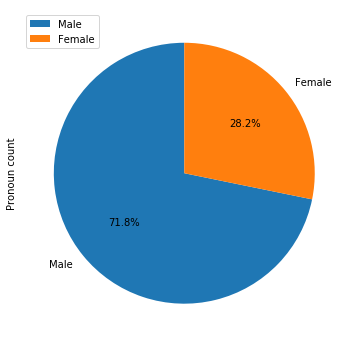

Sports:


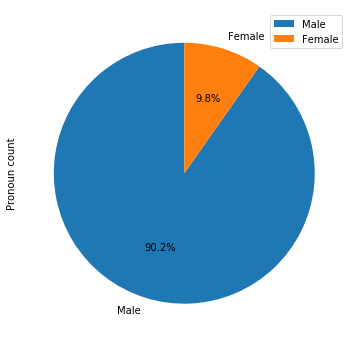

Opinion:


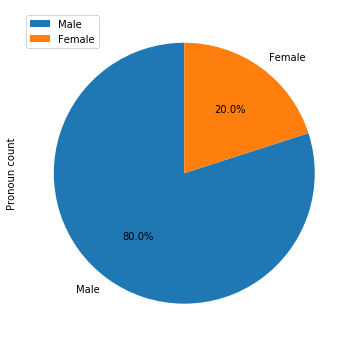

Business:


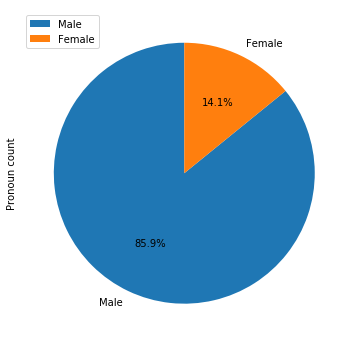

In [744]:
# Show pie chart for all the articles
df = pd.DataFrame({
'label': ["Male", "Female"],
'Pronoun count': [
    pd.Series(result['All']['male_pronoun_count']).sum(), 
    pd.Series(result['All']['female_pronoun_count']).sum()
],
'total': pd.Series(result['All']['word_count']).sum()
}, 
columns=['label', 'Pronoun count', 'total'])

print("All:")
df.plot(kind='pie', y='Pronoun count', autopct='%1.1f%%', startangle=90, labels=df['label'])

# Show pie chart for each category
for category in categories:
    df = pd.DataFrame({
    'label': ["Male", "Female"],
    'Pronoun count': [pd.Series(result[category]['male_pronoun_count']).sum(), pd.Series(result[category]['female_pronoun_count']).sum()],
    'total': pd.Series(result[category]['word_count']).sum()
    }, 
    columns=['label', 'Pronoun count', 'total'])
    
    plt.show()
    print(category + ":")
    df.plot(kind='pie', y='Pronoun count', autopct='%1.1f%%', startangle=90, labels=df['label'])



NameError: name 'difference_female_female' is not defined

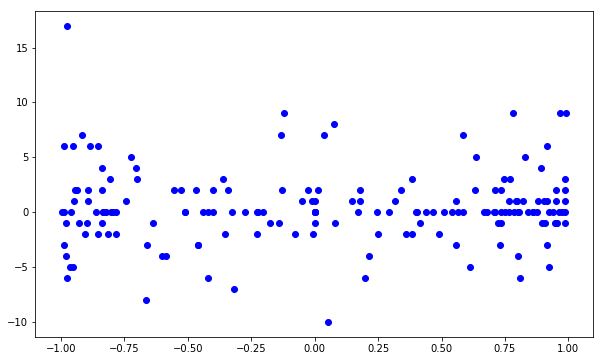

In [261]:
plt.scatter(compound_articles, difference_male_female, color='blue')
plt.show()

## Graph showing percentage of pronouns for respective gender

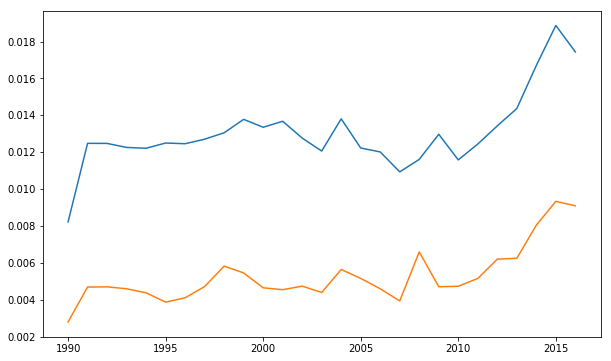

In [768]:
plt.plot(year, result['All']['male_pronoun_percentage'], label="Male")
plt.plot(year, result['All']['female_pronoun_percentage'], label="Female")

plt.show()
# Graph showing number of pronouns found for respective gender

## Graphs showing percentage of pronouns for respective gender and category

Sports:


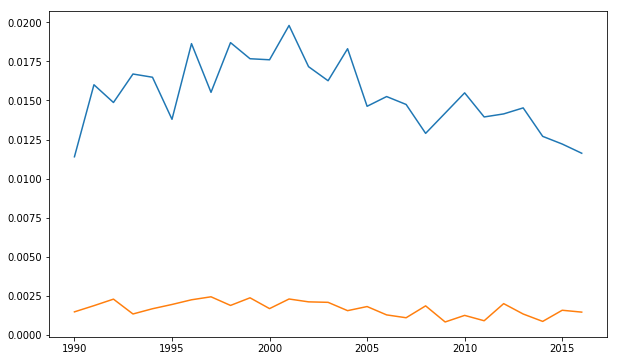

Opinion:


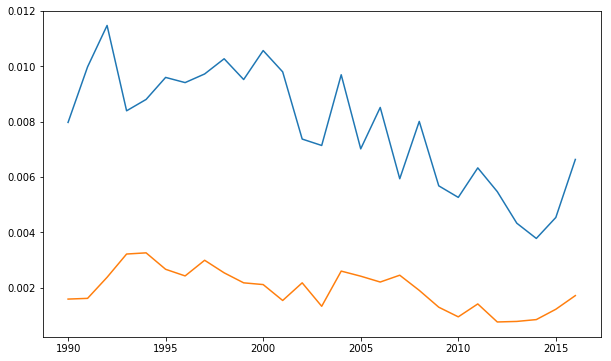

Business:


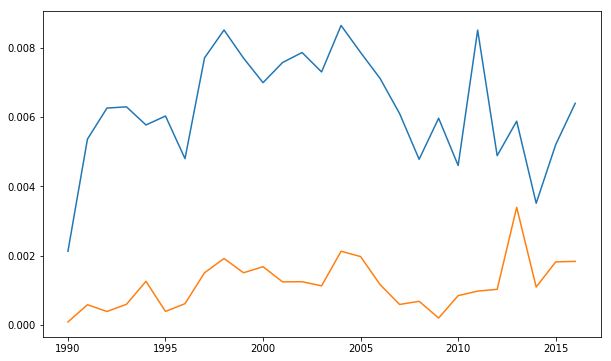

In [769]:
for category in categories:
    plt.plot(year, result[category]['male_pronoun_percentage'], label="Male " + category)
    plt.plot(year, result[category]['female_pronoun_percentage'], label="Female " + category)
    print(category + ":")
    plt.show()

# Graph showing number of pronouns found for respective gender

## Graph showing number of pronouns found for respective gender

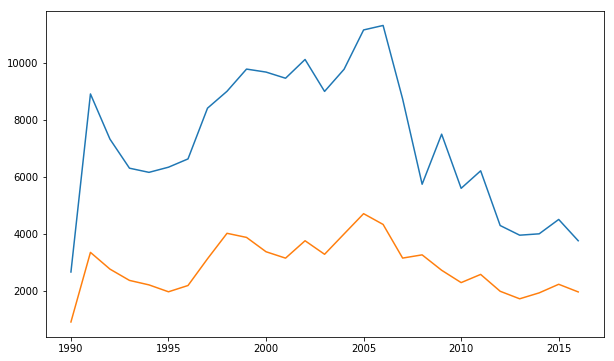

In [578]:
year = []
for number in year_span:
    year.append(number)

plt.plot(year, result['All']['male_pronoun_count'], label="Male")
plt.plot(year, result['All']['female_pronoun_count'], label="Female")

plt.show()
# Graph showing number of pronouns found for respective gender

## Graphs showing average attitude for the different categories

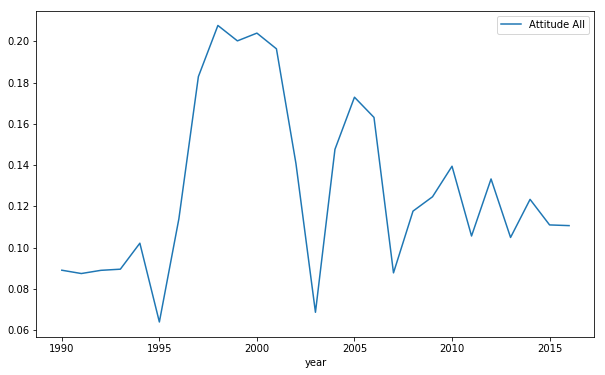

In [770]:
df = pd.DataFrame({'year': year, 'Attitude All': result['All']['attitude']})
df.plot(x='year')

# Graph showing average attitude for all articlces

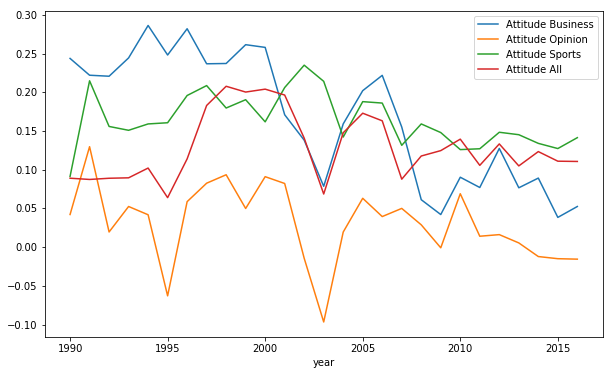

In [772]:
df = pd.DataFrame({'year': year, 'Attitude All': result['All']['attitude']})

for category in categories:
    catDF = pd.DataFrame({'year': year, 'Attitude ' + category: result[category]['attitude']})
    df = pd.merge(catDF, df, on='year')
    
df.plot(x='year')

# Graph showing average attitude for the different categories

## Table showing the pearson correlation between Attitude and Female & Male percentage

In [783]:
# Display tables showing the correlations between attitude and percentage of female and male pronouns
df = pd.DataFrame({
    "Female percentage": result["All"]["female_pronoun_percentage"], 
    "Male percentage": result["All"]["male_pronoun_percentage"], 
    "Attitude": result["All"]["attitude"]
})
frame = pd.DataFrame(df, columns=['Female percentage', 'Male percentage', 'Attitude'])
focus_cols = ['Attitude']
display(frame.corr().filter(focus_cols).drop(focus_cols))


for category in categories:
    df = pd.DataFrame({
        "Female percentage": result[category]["female_pronoun_percentage"], 
        "Male percentage": result[category]["male_pronoun_percentage"], 
        "Attitude": result[category]["attitude"]
    })
    frame = pd.DataFrame(df, columns=['Female percentage', 'Male percentage', 'Attitude'])
    focus_cols = ['Attitude']
    
    print("-------------------------")
    print("")
    print("")
    print(category + ":")
    display(frame.corr().filter(focus_cols).drop(focus_cols))




,Attitude
Female percentage,0.073608
Male percentage,0.134399


-------------------------


Sports:


,Attitude
Female percentage,0.671309
Male percentage,0.610581


-------------------------


Opinion:


,Attitude
Female percentage,0.265913
Male percentage,0.423873


-------------------------


Business:


,Attitude
Female percentage,-0.173949
Male percentage,0.101534


## Plots female and male percentage and collection attitude



All:


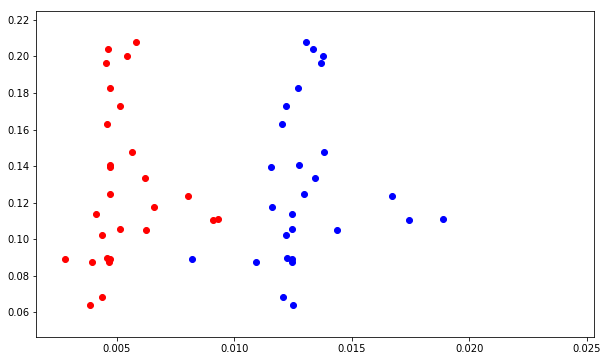

Sports:


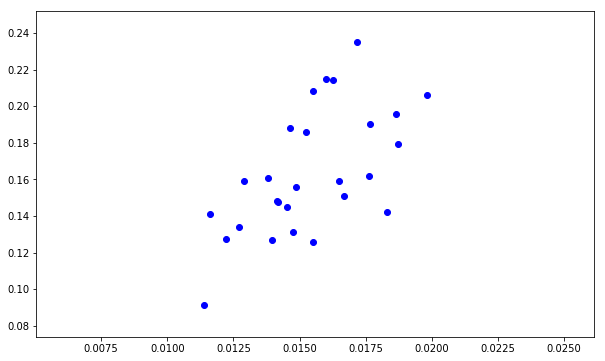

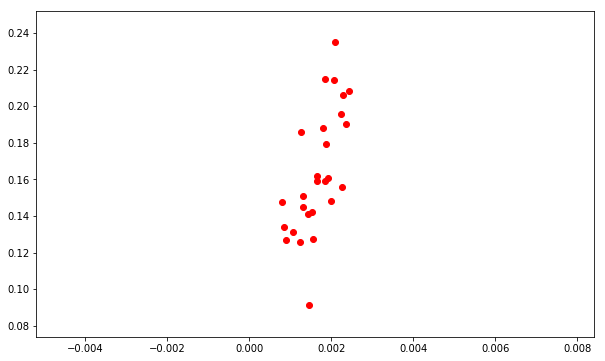

Opinion:


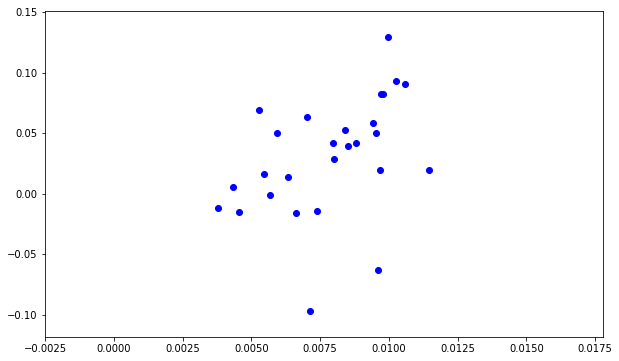

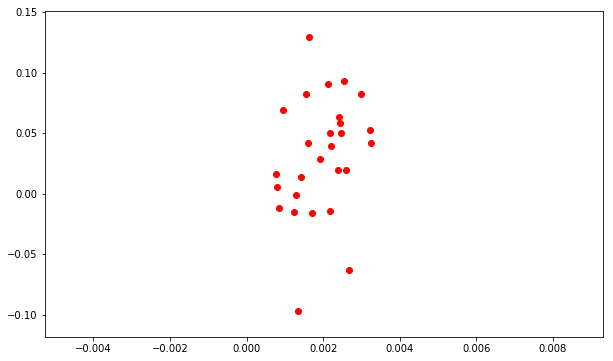

Business:


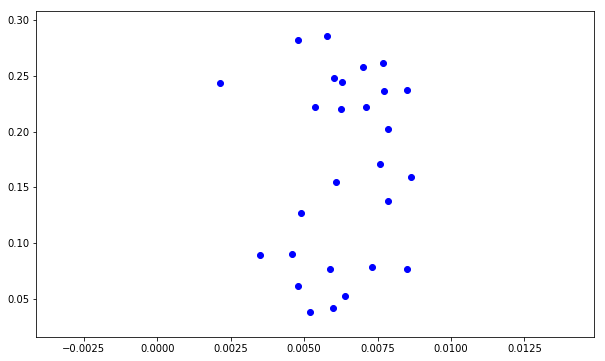

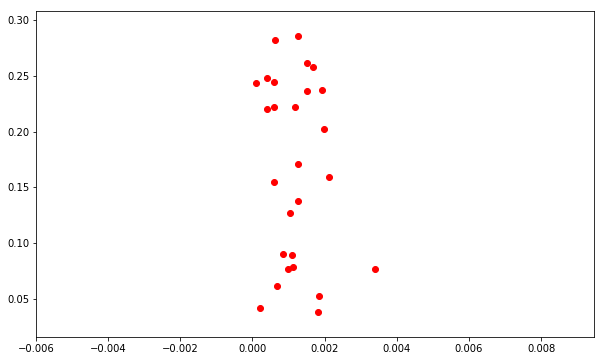

In [786]:
df1 = pd.DataFrame({
        'Male percentage': result['All']['male_pronoun_percentage'], 
        'Attitude': result['All']['attitude'],
})

df2 = pd.DataFrame({
        'Female percentage': result['All']['female_pronoun_percentage'], 
        'Attitude': result['All']['attitude'],
})

print("All:")
plt.figure(i) # Here's the part I need
plt.scatter(df1['Male percentage'], df2['Attitude'], c="blue")
plt.scatter(df2['Female percentage'], df1['Attitude'], c="red")
plt.show()



i = 0
for category in categories:
    i += 1
    df1 = pd.DataFrame({
        'Male percentage': result[category]['male_pronoun_percentage'], 
        'Attitude': result[category]['attitude'],
        'Category': category
    })

    df2 = pd.DataFrame({
        'Female percentage': result[category]['female_pronoun_percentage'], 
        'Attitude': result[category]['attitude'],
        'Category': category
    })
    
    print(category + ":")
    plt.figure(i) # Here's the part I need
    plt.scatter(df1['Male percentage'], df2['Attitude'], c="blue")
    plt.scatter(df2['Female percentage'], df1['Attitude'], c="red")
    
    # Put show in between the two scatters to show female and male in seperate plots
    plt.show()


## Saving files

In [487]:
joblib.dump(nyt_papers, "nyt_papers_lead_paragraph_" + str(year_span) + ".pkl")

['nyt_papers_lead_paragraph_range(1990, 2017).pkl']

## Data analysis

Our primary data mining analysis tool is classification. We have classified news items according to having majority male or majority female pronouns. Next, we have used the Natural Language Toolkit (www.nltk.org) to perform a sentiment analysis on these two sets, separating them into positive, neutral and negative. NLTK uses a machine learning algorithm trained on multiple corpora to make an emotional value judgment of text. As statistical methods of sentiment analysis are less accurate on smaller text units we have chosen to only run this on the lead paragraph of our material. (https://ieeexplore-ieee-org.ezproxy.its.uu.se/ielx7/9670/7435173/07435182.pdf?tp=&arnumber=7435182&isnumber=7435173)

In the next part of the study, we would like to examine if there is any significant relationship between author gender and the gender of the subject in the news item. This would require us to categorize names of reporters as male or female (or unknown), 


In [ ]:
# Add your own code

## Evaluation of results

* Clear difference in female and male representation in New York Times articlces. This could be for several reasons and as we can see in the pilot study it differs from category to category. But as the differens is so large, at least 1/4 female representations over the time, it's easy to find a pattern. Although the big difference in representation it has at least gotten better in the previous years. Although it's hard to determine if the progress actually is a positive trend or only fluctuation, compared to the early 90s where we can see the same pattern.

In [ ]:
# Add your own code

## Schedule and description of project plan

* Compare with other datasets containing female and male status in society, for example: degrees (e.g. B.A, PHD, Law), age of first child, income differences.
* Look at the unsampled dataset, all articles instead of a small sample of the data.
* Look at different types of articles and subjects in the dataset, is there a correlation of the article subject and mentions of female pronouns.
* Look at how results differ when presented on female and male journalists.
* Compare results to: https://link-springer-com.ezproxy.its.uu.se/article/10.1007/s11199-012-0194-7?fbclid=IwAR0TE1PxHMRFEU96SPj0RF8d1MSVO1ntbOqqh4FYxcjAHOWvHefWpvLpisM
* Do same comparison on Twitter data.

For a more accurate and reliable conclusion an analysis of the complete dataset, rather than the current sample set, should be carried out. Taking the project further a comparison with a dataset containing more opinionated data from the average person, like Twitter, would be of interest with its contrast to the New York Times articles, which in its nature try to stay as neutral as possible. Could more distinct patterns be found amongst the unfiltered voiced opinion of the public? Could the outcome if so further confirm the currently reached conclusion that New York Times has managed to maintain its objectivity through the years? 


## Ethical aspects that need to be considered

As with all big data projects, more data does not necessarily guarantee better data. As such, we would encourage some caution in how this report is used.

Newspapers do have an obligation to report things that happen, rather than whatever fits a desired mold of society. Our findings are only meant to highlight potential bias that may be controlling which part of the world’s happenings get covered. As such, we are not suggesting that journalists under NYT employ should be attempting to remove all disparity in their reporting at the expense of the truth. In fact, attempts to do so may even harm society; because of the news’ role as informant to the public, artificially inflating the frequency of actions of men or women may give people a skewed sense of the world. We only mean to encourage an awareness of perspectives that might get missed when reporting. Rather than news items being written with an unconscious limitation on sources and content, we would like these decisions to be made from an informed position and with intent.
	
If the full study goes ahead and involves perceived author gender, further issues could arise. We would strongly suggest anonymizing the data as much as possible by removing the name as soon as the gender has been determined. However, even after anonymizing the data, it is possible that the more recent results could have some fallout. 


## References

Armstrong, C. L. (2004) ‘The Influence of Reporter Gender on Source Selection in Newspaper Stories’, Journalism & Mass Communication Quarterly, 81(1), pp. 139–154. Available at: https://search-ebscohost-com.ezproxy.its.uu.se/login.aspx?direct=true&db=eue&AN=507903756&site=ehost-live (Accessed: 13 November 2018).

Carlsen, A., Salam, M., Miller, C.C., Lu, D. Ngu, A. Patel, J.K., & Wichter, Z. (2018) ‘#MeToo Brought Down 201 Powerful Men. Nearly Half of Their Replacements Are Women.’ The New York Times, updated 19th Oct [Online]. Available: https://www.nytimes.com/interactive/2018/10/23/us/metoo-replacements.html (Accessed on 2018-11-12)

Collins, R. L. (2011). Content analysis of gender roles in media: Where are we now and where should we go? Sex Roles, 64(3-4), 290-298. doi:http://dx.doi.org.ezproxy.its.uu.se/10.1007/s11199-010-9929-5